In [1]:
# import pydicom
import numpy
import os
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing Notebook

Here is a notebook to help with data preprocessing. This uses the RSNA competition data. Link to competition data: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

## Displaying Data

I'll go through a series of steps on how to display dcm data and its associated bounding box(es).

In [2]:
base_folder = '../../nih_data_vol/bbox_images/'
data_files = os.listdir(base_folder)
data_files = [base_folder + file for file in data_files]
data_files[:5]

['../../nih_data_vol/bbox_images/00016522_023.png',
 '../../nih_data_vol/bbox_images/00000032_037.png',
 '../../nih_data_vol/bbox_images/00000072_000.png',
 '../../nih_data_vol/bbox_images/00000147_001.png',
 '../../nih_data_vol/bbox_images/00000149_006.png']

Lets display one of these files.

Lets get the label for this image and display it.

In [3]:
base_folder_labels = '../../nih_data_vol/BBox_List_2017.csv'
base_folder_paths = '../../nih_data_vol/image_paths.csv'
label_df = pd.read_csv(base_folder_labels)
path_df = pd.read_csv(base_folder_paths)
label_df = label_df.merge(path_df, on='Image Index')
label_df = label_df.rename(columns={
    'Finding Label': 'Target',
    'Bbox [x': 'x', 'h]': 'h',
    'Image Index': 'Image_Index'
})

def correct_path(x):
    tf_path = '/home/tensorflow/aeolux2/nih_data_vol/bbox_images_jpgs/'
    suffix = x.replace(".png", ".jpgs")
    return tf_path + suffix

def correct_jpg_path(x):
    x = x.replace('.png', '.jpg')
    jpg_path = '../../nih_data_vol/bbox_images_jpgs/'
    return os.path.join(jpg_path, x)

label_df['jpg_path'] = label_df['Image_Index'].apply(correct_jpg_path)
label_df['fake_path'] = label_df['Image_Index'].apply(correct_path)
label_df = label_df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'])
label_df.head()

,Image_Index,Target,x,y,w,h,path,jpg_path,fake_path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,../../nih_data_vol/images_006/images/00013118_...,../../nih_data_vol/bbox_images_jpgs/00013118_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,../../nih_data_vol/images_007/images/00014716_...,../../nih_data_vol/bbox_images_jpgs/00014716_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,../../nih_data_vol/images_012/images/00029817_...,../../nih_data_vol/bbox_images_jpgs/00029817_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,../../nih_data_vol/images_007/images/00014687_...,../../nih_data_vol/bbox_images_jpgs/00014687_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,../../nih_data_vol/images_008/images/00017877_...,../../nih_data_vol/bbox_images_jpgs/00017877_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...


In [4]:
sample_id = '00014716_007.png'
sample_bbox = label_df.query(f"Image_Index == '{sample_id}'")
sample_bbox

,Image_Index,Target,x,y,w,h,path,jpg_path,fake_path
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,../../nih_data_vol/images_007/images/00014716_...,../../nih_data_vol/bbox_images_jpgs/00014716_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...


In [5]:
bbox_coords = sample_bbox[['x', 'y', 'w', 'h']].values
sample_path = sample_bbox['path'].values[0]
sample_fake_path = sample_bbox['fake_path'].values[0]
sample_jpg_path = sample_bbox['jpg_path'].values[0]
bbox_coords, sample_path, sample_fake_path, sample_jpg_path

(array([[686.10169492, 131.54349841, 185.49152542, 313.49152542]]),
 '../../nih_data_vol/images_007/images/00014716_007.png',
 '/home/tensorflow/aeolux2/nih_data_vol/bbox_images_jpgs/00014716_007.jpgs',
 '../../nih_data_vol/bbox_images_jpgs/00014716_007.jpg')

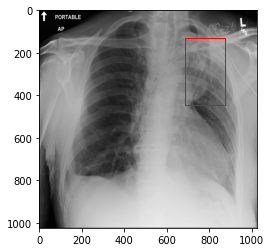

In [6]:
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np

sample_img = Image.open(sample_path).convert('RGB')
sample_img = np.array(sample_img)
plt.imshow(sample_img, cmap=plt.cm.bone)
ax = plt.gca()
for bbox_coord in bbox_coords:
    x, y, w, h = bbox_coord
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

## PASCAL VOC Label Conversion

It might be advantageous for us to convert our labels into PASCAL VOC label format. A typical example is as follows:

```
<annotation>
	<folder>GeneratedData_Train</folder>
	<filename>000001.png</filename>
	<path>/my/path/GeneratedData_Train/000001.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>224</width>
		<height>224</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>21</name>
		<pose>Frontal</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>82</xmin>
			<xmax>172</xmax>
			<ymin>88</ymin>
			<ymax>146</ymax>
		</bndbox>
	</object>
</annotation>
```

An explanation of the fields can be found here: https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5

In [35]:
from tqdm import tqdm

In [36]:
def make_pascal_voc(src, folder, filename, bbox_coords, img_shape):
    object_xml = ''
    
    def isNan(x):
        return x != x
    
    for bbox_coord in bbox_coords:
        x, y, w, h, target = bbox_coord
        xmin, xmax, ymin, ymax = x, x + w, y, y + h
        
        if target == 0:
            continue
            
        if xmin > xmax:
            print(src)

        object_xml += f"""\n    <object>
        <name>{target}</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <occluded>0</occluded>
        <bndbox>
            <xmin>{xmin}</xmin>
            <xmax>{xmax}</xmax>
            <ymin>{ymin}</ymin>
            <ymax>{ymax}</ymax>
        </bndbox>
    </object>"""
        
    return f"""<annotation>
    <folder>{folder}</folder>
    <filename>{filename}</filename>
    <path>{folder}/{filename}</path>
    <source>
        <database>{src}</database>
    </source>
    <size>
        <width>{img_shape[0]}</width>
        <height>{img_shape[1]}</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>{object_xml}
</annotation>"""

In [39]:
from tqdm import tqdm

pascal_voc_groups = {}
# Image_Index Target x y w h path fake_path
for row in tqdm(label_df.iterrows()):
    index, (iid, target, x, y, w, h, path, jpg_path, fake_path) = row
    if iid not in pascal_voc_groups:
        pascal_voc_groups[iid] = []
    pascal_voc_groups[iid].append((x, y, w, h, target, fake_path))

1216it [00:00, 11057.00it/s]


In [40]:
max([len(pascal_voc_groups[k]) for k in pascal_voc_groups.keys()])

16

In [41]:
from pathlib import Path

for iid, data_row in tqdm(pascal_voc_groups.items()):
    fake_path = data_row[0][-1]
    data_row = [d_row[:-1] for d_row in data_row]
    img_w, img_h = 1024, 1024
    
    if len(data_row) == 0:
        continue
    
    pv_str = make_pascal_voc(
        'nih',
        '/'.join(fake_path.split('/')[:-1]), 
        iid.replace('.png', '.jpg'), 
        data_row, (img_w, img_h))
    
    iid = iid.replace('.png', '')
    pv_filename = f'../../nih_data_vol/pascal_labels/{iid}.xml'
    with open(pv_filename, 'w') as f:
        f.write(pv_str)

100%|██████████| 880/880 [00:00<00:00, 3847.08it/s]


In [42]:
len(os.listdir('../../nih_data_vol/bbox_images/')), len(os.listdir('../../nih_data_vol/pascal_labels/'))

(880, 880)

In [43]:
# Checking contents of file with bounding boxes
another_sample_pid2 = '00014716_007'
base_label_path = '../../nih_data_vol/pascal_labels'
with open(f'{base_label_path}/{another_sample_pid2}.xml', 'r') as f:
    file_content = f.read()
print(file_content)

<annotation>
    <folder>/home/tensorflow/aeolux2/nih_data_vol/bbox_images_jpgs</folder>
    <filename>00014716_007.jpg</filename>
    <path>/home/tensorflow/aeolux2/nih_data_vol/bbox_images_jpgs/00014716_007.jpg</path>
    <source>
        <database>nih</database>
    </source>
    <size>
        <width>1024</width>
        <height>1024</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>Atelectasis</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <occluded>0</occluded>
        <bndbox>
            <xmin>686.101694915254</xmin>
            <xmax>871.593220338983</xmax>
            <ymin>131.543498411017</ymin>
            <ymax>445.03502383474597</ymax>
        </bndbox>
    </object>
</annotation>


## Create JPGS from PNGS

In [47]:
png_path = '../../nih_data_vol/bbox_images/'
png_files = os.listdir(png_path)
png_files = [os.path.join(png_path, x) for x in png_files]

In [48]:
from PIL import Image

jpg_path = '../../nih_data_vol/bbox_images_jpgs'
for png_file in tqdm(png_files):
    img_png = Image.open(png_file).convert('RGB')
    jpg_name = png_file.split("/")[-1].replace(".png", ".jpg")
    img_png.save(os.path.join(jpg_path, jpg_name))

100%|██████████| 880/880 [00:31<00:00, 28.09it/s]


In [49]:
len(os.listdir(jpg_path))

880

## Moving Files to tf_obj_files

In [50]:
splits_df = pd.read_csv('./auto_ml_nih.csv', header=None)
splits_df = splits_df[[0, 1]]
splits_df[1] = splits_df[1].apply(lambda x : x.split("/")[-1])
splits_df.columns = ['set', 'Image_Index']
splits_df = splits_df.drop_duplicates('Image_Index')
splits_df

,set,Image_Index
0,TRAINING,00012299_002.png
1,TRAINING,00019861_010.png
2,TRAINING,00003394_006.png
3,TRAINING,00025686_000.png
4,TRAINING,00021132_000.png
...,...,...
977,TEST,00019706_002.png
978,TEST,00018686_000.png
980,TEST,00012415_002.png
981,TEST,00012636_000.png


In [51]:
# Checking on intersections
train_set = splits_df.query("set == 'TRAINING'")
eval_set = splits_df.query("set == 'VALIDATION'")
test_set = splits_df.query("set == 'TEST'")

train_set = set(train_set['Image_Index'].values.tolist())
eval_set = set(eval_set['Image_Index'].values.tolist())
test_set = set(test_set['Image_Index'].values.tolist())

In [52]:
train_set.intersection(eval_set)

set()

In [53]:
train_set.intersection(test_set)

set()

In [54]:
test_set.intersection(eval_set)

set()

In [55]:
big_splits_df = splits_df.merge(label_df, on='Image_Index')
big_splits_df

,set,Image_Index,Target,x,y,w,h,path,jpg_path,fake_path
0,TRAINING,00012299_002.png,Atelectasis,195.527118,575.905191,658.773333,79.644444,../../nih_data_vol/images_006/images/00012299_...,../../nih_data_vol/bbox_images_jpgs/00012299_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
1,TRAINING,00019861_010.png,Cardiomegaly,269.815873,357.587302,534.213757,396.596825,../../nih_data_vol/images_009/images/00019861_...,../../nih_data_vol/bbox_images_jpgs/00019861_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
2,TRAINING,00003394_006.png,Cardiomegaly,312.949153,375.629386,441.491525,303.728814,../../nih_data_vol/images_002/images/00003394_...,../../nih_data_vol/bbox_images_jpgs/00003394_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
3,TRAINING,00025686_000.png,Effusion,596.764444,670.473490,332.231111,104.675556,../../nih_data_vol/images_011/images/00025686_...,../../nih_data_vol/bbox_images_jpgs/00025686_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
4,TRAINING,00021132_000.png,Effusion,705.422222,204.800000,160.372487,475.699471,../../nih_data_vol/images_010/images/00021132_...,../../nih_data_vol/bbox_images_jpgs/00021132_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
...,...,...,...,...,...,...,...,...,...,...
1211,TEST,00019706_002.png,Pneumothorax,576.474074,89.938624,152.787302,119.195767,../../nih_data_vol/images_009/images/00019706_...,../../nih_data_vol/bbox_images_jpgs/00019706_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
1212,TEST,00018686_000.png,Cardiomegaly,353.252910,307.741799,497.371429,452.943915,../../nih_data_vol/images_009/images/00018686_...,../../nih_data_vol/bbox_images_jpgs/00018686_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
1213,TEST,00012415_002.png,Nodule,398.764021,534.213757,74.768254,86.687831,../../nih_data_vol/images_006/images/00012415_...,../../nih_data_vol/bbox_images_jpgs/00012415_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...
1214,TEST,00012636_000.png,Atelectasis,775.856085,532.046561,119.195767,69.350265,../../nih_data_vol/images_006/images/00012636_...,../../nih_data_vol/bbox_images_jpgs/00012636_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...


In [63]:
big_splits_df.query("Image_Index == '00000032_037.png'")

,set,Image_Index,Target,x,y,w,h,path,jpg_path,fake_path
859,TRAINING,00000032_037.png,Infiltrate,339.166138,119.195767,172.292063,351.085714,../../nih_data_vol/images_001/images/00000032_...,../../nih_data_vol/bbox_images_jpgs/00000032_0...,/home/tensorflow/aeolux2/nih_data_vol/bbox_ima...


In [59]:
from shutil import copyfile

nih_tf_path = '../../nih_data_vol/tf_obj_files/'
xml_path = '../../nih_data_vol/pascal_labels/'
tf_obj_paths = {
    'TRAINING': (os.path.join(nih_tf_path, 'train'), os.path.join(nih_tf_path, 'train_labels')),
    'VALIDATION': (os.path.join(nih_tf_path, 'eval'), os.path.join(nih_tf_path, 'eval_labels')),
    'VALIDATE': (os.path.join(nih_tf_path, 'eval'), os.path.join(nih_tf_path, 'eval_labels')),
    'TEST': (os.path.join(nih_tf_path, 'test'), os.path.join(nih_tf_path, 'test_labels'))
}

for index, data_row in tqdm(big_splits_df.iterrows()):
    dataset = data_row['set']
    img_path = data_row['jpg_path']
    img_name = data_row['Image_Index'].split(".")[0]
    img_xml_path = os.path.join(xml_path, img_name + '.xml')
    
    assert os.path.isfile(img_path), "Couldn't find jpg"
    assert os.path.isfile(img_xml_path), "Couldn't find xml"
    
    copy_data_path, copy_label_path = tf_obj_paths[dataset]
    copyfile(img_path, os.path.join(copy_data_path, img_name + ".jpg"))
    copyfile(img_xml_path, os.path.join(copy_label_path, img_name + ".xml"))

1216it [00:02, 567.16it/s]


In [60]:
splits_df.groupby('set').count()

,Image_Index
set,
TEST,158
TRAINING,584
VALIDATION,138


In [61]:
for k, (tf_data_path, tf_label_path) in tf_obj_paths.items():
    print(k, len(os.listdir(tf_data_path)), len(os.listdir(tf_label_path)))

TRAINING 584 584
VALIDATION 138 138
VALIDATE 138 138
TEST 158 158
